In [2]:
%load_ext autoreload
%autoreload 2

### Load libraries and paths

In [3]:
import sys
sys.path.append("../../..")

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import pymc as pm 

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from config.config import BASE_PATH, PATH_TO_PATH_CONFIG_FILE, PROJECT_EPSG
from src.utils import load_paths_from_yaml, replace_base_path
from src.modeling.encodings import (convert_aspect_to_cardinal_direction, 
                                    convert_population_to_classes, 
                                    convert_elevation_to_classes, 
                                    convert_slope_to_classes, 
                                    apply_encoding, 
                                    naturraumregionen_encoding, 
                                    map_to_binary)
from src.modeling.utils import temporal_train_test_split, save_model, load_model
from src.modeling.bayesian_models import create_blr_v2, create_st_blr_v2, create_bnn, create_st_intercept_blr_v2
from src.modeling.predictions import BinaryClassification, BinaryClassificationBNN
from src.visualization import (plot_st_sample_size_distribution, 
                               plot_performance_over_test_years,
                               plot_performance_over_seasons)

In [5]:
paths = load_paths_from_yaml(PATH_TO_PATH_CONFIG_FILE)
paths = replace_base_path(paths, BASE_PATH)

### Read in data

In [6]:
# read in training data
training_data = gpd.read_file(paths["training_data"])
training_data.date = pd.to_datetime(training_data.date)

# read in Naturraumregionen
naturraumregionen = gpd.read_file(paths["naturraumregionen"])
naturraumregionen.to_crs(PROJECT_EPSG, inplace=True)

### Data Cleaning & Preparation

In [7]:
# rename columns
training_data.rename(columns={"farmyard_d": "farmyard_density", 
                              "hiking_ds": "hikingtrail_density", 
                              "forest_ds": "forestroad_density", 
                              "rail_dens": "railway_density", 
                              "foresttype": "forest_type", 
                              "pop_dens": "population_density"}, inplace=True)

training_data = training_data.sjoin(naturraumregionen.loc[:, ["EINHEIT", "geometry"]])
training_data.drop(columns=["index_right"], inplace=True)

# create season column (0 = winter (1,2,3), 1 = spring (4,5,6), 2 = sommer (7,8,9), 3 = winter (10,11,12))
training_data["season"] = (training_data.date.dt.month -1) // 3 

# encode features into predefined classes
training_data["naturraumregionen_encoded"] = training_data["EINHEIT"].apply(apply_encoding, mapping=naturraumregionen_encoding)
training_data["elevation_encoded"] = training_data["elevation"].apply(convert_elevation_to_classes)
training_data["slope_encoded"] = training_data["slope"].apply(convert_slope_to_classes)
training_data["aspect_encoded"] = training_data["aspect"].apply(convert_aspect_to_cardinal_direction)
training_data["population_encoded"] = training_data["population_density"].apply(convert_population_to_classes)

# binarize features
training_data["farmyard_density_bin"] = training_data["farmyard_density"].apply(map_to_binary)
training_data["forestroad_density_bin"] = training_data["forestroad_density"].apply(map_to_binary)
training_data["railway_density_bin"] = training_data["railway_density"].apply(map_to_binary)
training_data["hikingtrail_density_bin"] = training_data["hikingtrail_density"].apply(map_to_binary)

# deal with missing data in forest type feature
training_data["forest_type"].fillna(6, inplace=True)
training_data["forest_type"] = training_data["forest_type"].astype(int)

/tmp/ipykernel_6672/3938864487.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  training_data["forest_type"].fillna(6, inplace=True)


### Temporal train test split

In [8]:
X_train_unprocessed, X_test_unprocessed = temporal_train_test_split(training_data, "date", 0.7)
y_train, y_test = X_train_unprocessed["fire"], X_test_unprocessed["fire"]

print("The following gives us the split date:")
print(X_train_unprocessed.date.max())
print(X_test_unprocessed.date.min())

The following gives us the split date:
2016-05-09 00:00:00
2016-05-11 00:00:00


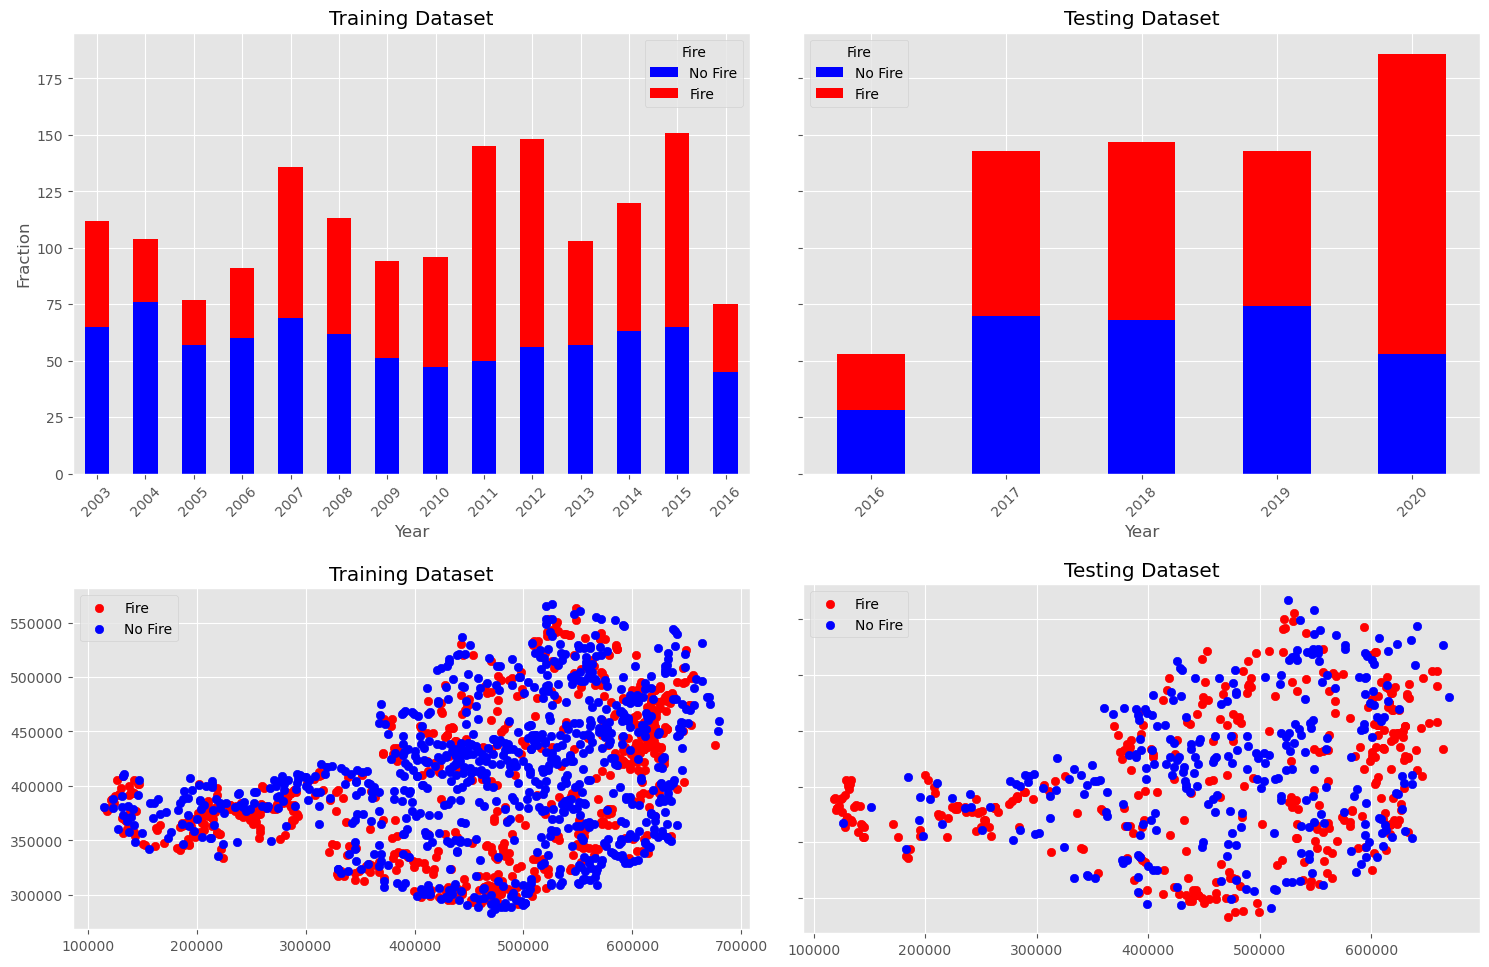

In [9]:
# Plotting the distribution of fire and no-fire samples for train and test set
plot_st_sample_size_distribution(X_train_unprocessed, X_test_unprocessed, r"../../../results/train_test_distribution.png")

### Feature Preprocessing

In [10]:
# feature processing for BLR and ST_BLR
preprocessor_blr = ColumnTransformer(
    transformers=[
        ('std_scaler', StandardScaler(), ["ffmc"])
    ],
    remainder='drop',
)

preprocessor_blr.fit(X_train_unprocessed)
train_ffmc_scaled = preprocessor_blr.transform(X_train_unprocessed)
test_ffmc_scaled = preprocessor_blr.transform(X_test_unprocessed)

X_train = X_train_unprocessed.copy()
X_test = X_test_unprocessed.copy()
X_train["ffmc"] = train_ffmc_scaled
X_test["ffmc"] = test_ffmc_scaled

# feature processing for BNN
features_to_scale = ['ffmc', 'farmyard_density',
       'hikingtrail_density', 'forestroad_density', 'railway_density',
       'elevation', 'slope', 'population_density']
features_bnn_ohe = ['aspect_encoded', 'forest_type']

preprocessor_bnn = ColumnTransformer(
    transformers=[
        ('std_scaler', StandardScaler(), features_to_scale),
        ('ohe', OneHotEncoder(), features_bnn_ohe)
    ],
    remainder='drop',
)

# scaler
preprocessor_bnn.fit(X_train_unprocessed)
X_train_bnn = preprocessor_bnn.fit_transform(X_train_unprocessed)
X_test_bnn = preprocessor_bnn.transform(X_test_unprocessed)

### Modeling

In [11]:
coords = {"elevation_classes": [0, 1, 2, 3, 4, 5], 
          "slope_classes": [0, 1, 2, 3, 4], 
          "aspect_classes": [0, 1, 2, 3, 4, 5, 6, 7],
          "forest_type_classes": [0, 1, 2, 3, 4, 5, 6], 
          "population_classes": [0, 1, 2, 3, 4, 5], 
          "farmyard_density_classes": [0, 1], 
          "forestroad_density_classes": [0, 1], 
          "railway_density_classes": [0, 1], 
          "hikingtrail_density_classes": [0, 1], 
          "spatial_groups": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 
          "temporal_groups": [0, 1, 2, 3]}

In [18]:
# Create simple Bayesian Log Reg Model
model_blr = create_blr_v2(X_train, y_train, coords)
with model_blr:
    approx = pm.fit(n=20000, random_seed=0)
    blr_idata = approx.sample()
    pm.compute_log_likelihood(blr_idata)

save_model("../../../models/blr_v2.pkl", model_blr, blr_idata)

/home/david/miniconda3/envs/ignite_pymc_env/lib/python3.12/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

Finished [100%]: Average Loss = 786.51


Output()

In [25]:
model_st_intercept_blr = create_st_intercept_blr_v2(X_train, y_train, coords, "naturraumregionen_encoded", "season")
with model_st_intercept_blr:
    approx = pm.fit(n=20000, random_seed=0)
    st_intercept_blr_idata = approx.sample()
    pm.compute_log_likelihood(st_intercept_blr_idata)

save_model("../../../models/st_intercept_blr_v2.pkl", model_st_intercept_blr, st_intercept_blr_idata)

/home/david/miniconda3/envs/ignite_pymc_env/lib/python3.12/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

Finished [100%]: Average Loss = 779.44


Output()

In [24]:
# Spatio temporal Bayesian Logistic Regression Model
model_st_blr = create_st_blr_v2(X_train, y_train, coords, "naturraumregionen_encoded", "season")
with model_st_blr:
    approx = pm.fit(n=20000, random_seed=0)
    st_blr_idata = approx.sample()
    pm.compute_log_likelihood(st_blr_idata)

save_model("../../../models/st_blr_v2.pkl", model_st_blr, st_blr_idata)

/home/david/miniconda3/envs/ignite_pymc_env/lib/python3.12/site-packages/pymc/data.py:303: FutureWarning: MutableData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(


Output()

Finished [100%]: Average Loss = 1,231.4


Output()

In [21]:
model_bnn = create_bnn(X_train_bnn, y_train)

with model_bnn:
    approx = pm.fit(n=20000, random_seed=0)
    bnn_idata = approx.sample()

save_model("../../../models/bnn.pkl", model_bnn, bnn_idata)

/home/david/miniconda3/envs/ignite_pymc_env/lib/python3.12/site-packages/pymc/data.py:416: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


Output()

Finished [100%]: Average Loss = 889.04


### Out-of-sample prediction

In [11]:
# open saved models
model_blr, idata_blr = load_model("../../../models/blr_v2.pkl")
model_st_blr, idata_st_blr = load_model("../../../models/st_blr_v2.pkl")
model_st_intercept_blr, idata_st_intercept_blr = load_model("../../../models/st_intercept_blr_v2.pkl")
model_bnn, idata_bnn = load_model("../../../models/bnn.pkl")

In [12]:
y_dummy = [0 for i in y_test]
X_new_blr = {
    "elevation": X_test.elevation_encoded,
    "slope": X_test.slope_encoded,
    "aspect": X_test.aspect_encoded,
    "forestroad_density": X_test.forestroad_density_bin,
    "railway_density": X_test.railway_density_bin,
    "hikingtrail_density": X_test.hikingtrail_density_bin,
    "farmyard_density": X_test.farmyard_density_bin,
    "population": X_test.population_encoded,
    "forest_type": X_test.forest_type,
    "ffmc": X_test.ffmc,
    "fire": y_dummy
    }

X_new_st_blr = X_new_blr.copy()
X_new_st_blr["spatial_groups_idx"] = X_test.naturraumregionen_encoded
X_new_st_blr["temporal_groups_idx"] = X_test.season

In [13]:
seed = 0

# predictions for blr model
blr_prediction_obj = BinaryClassification(model_blr, idata_blr, X_new_blr, seed, "y_pred", "p")
blr_prediction_obj.extend_trace()
blr_preds = blr_prediction_obj.predict()

# predictions for st_intercept_blr model
st_intercept_blr_prediction_obj = BinaryClassification(model_st_intercept_blr, idata_st_intercept_blr, X_new_st_blr, seed, "y_pred", "p")
st_intercept_blr_prediction_obj.extend_trace()
st_intercept_blr_preds = st_intercept_blr_prediction_obj.predict()

# predictions for st_blr model
st_blr_prediction_obj = BinaryClassification(model_st_blr, idata_st_blr, X_new_st_blr, seed, "y_pred", "p")
st_blr_prediction_obj.extend_trace()
st_blr_preds = st_blr_prediction_obj.predict()

# predictions for bnn model
bnn_prediction_obj = BinaryClassificationBNN(model_bnn, idata_bnn, X_test_bnn, seed, "y_pred", "p")
bnn_prediction_obj.extend_trace()
bnn_preds = bnn_prediction_obj.predict()


Sampling: [y_pred]


Output()

Sampling: [y_pred]


Output()

Sampling: [y_pred]


Output()

Sampling: [y_pred]


Output()

### Analyze & Visualize results

#### Calculate overall model performance

In [14]:

print("BLR Accuracy: ", accuracy_score(y_test, blr_preds.y_pred))
print("BLR Precision: ", precision_score(y_test, blr_preds.y_pred))
print("BLR Recall: ", recall_score(y_test, blr_preds.y_pred))
print("HDI width: ", blr_preds.hdi_width.mean())

print("---------------------------------")

print("ST Intercept BLR Accuracy: ", accuracy_score(y_test, st_intercept_blr_preds.y_pred))
print("ST Intercept BLR Precision: ", precision_score(y_test, st_intercept_blr_preds.y_pred))
print("ST Intercept BLR  Recall: ", recall_score(y_test, blr_preds.y_pred))
print("HDI width: ", st_intercept_blr_preds.hdi_width.mean())

print("---------------------------------")

print("ST BLR Accuracy: ", accuracy_score(y_test, st_blr_preds.y_pred))
print("ST BLR Precision: ", precision_score(y_test, st_blr_preds.y_pred))
print("ST BLR Recall: ", recall_score(y_test, blr_preds.y_pred))
print("HDI width: ", st_blr_preds.hdi_width.mean())

print("---------------------------------")

print("BNN Accuracy: ", accuracy_score(y_test, bnn_preds.y_pred))
print("BNN Precision: ", precision_score(y_test, bnn_preds.y_pred))
print("BNN Recall: ", recall_score(y_test, blr_preds.y_pred))
print("HDI width: ", bnn_preds.hdi_width.mean())

BLR Accuracy:  0.7708333333333334
BLR Precision:  0.8260869565217391
BLR Recall:  0.7519788918205804
HDI width:  0.19818444432718985
---------------------------------
ST Intercept BLR Accuracy:  0.78125
ST Intercept BLR Precision:  0.8333333333333334
ST Intercept BLR  Recall:  0.7519788918205804
HDI width:  0.23065761596410356
---------------------------------
ST BLR Accuracy:  0.7470238095238095
ST BLR Precision:  0.7943661971830986
ST BLR Recall:  0.7519788918205804
HDI width:  0.4192507396808526
---------------------------------
BNN Accuracy:  0.7544642857142857
BNN Precision:  0.786096256684492
BNN Recall:  0.7519788918205804
HDI width:  0.27872929902007837


In [ ]:
# Performance (Accuracy & F1) over years and across seasons (4 plots)
model_preds = [(blr_preds, "blr"), (st_intercept_blr_preds, "st_intercept_blr"), (st_blr_preds, "st_blr"), (bnn_preds, "bnn")]
plot_performance_over_test_years(model_preds, X_test, y_test, "../../../results/model_performance_over_years.png")

#### Plot spatio-temporal model performance

In [16]:
spatial_groups = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
temporal_groups = [0, 1, 2, 3]
naturraumregionen["EINHEIT_encoded"] = naturraumregionen["EINHEIT"].apply(apply_encoding, mapping=naturraumregionen_encoding)

In [25]:
preds = st_intercept_blr_preds.copy()
preds["spatial_group"] = X_test.naturraumregionen_encoded.values
preds["temporal_group"] = X_test.season.values
preds["y_true"] = y_test.values

In [54]:
def calculate_st_metrics(group):
    accuracy = accuracy_score(group['y_true'], group['y_pred'])
    f1 = f1_score(group['y_true'], group['y_pred'])
    sample_size = len(group)
    return pd.Series({'accuracy': accuracy, 'f1': f1, 'sample_size': sample_size})

preds_st_grouped = preds.groupby(["spatial_group", "temporal_group"]).apply(calculate_st_metrics).reset_index()

/home/david/miniconda3/envs/ignite_pymc_env/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_6672/1351726271.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  preds_st_grouped = preds.groupby(["spatial_group", "temporal_group"]).apply(calculate_st_metrics).reset_index()


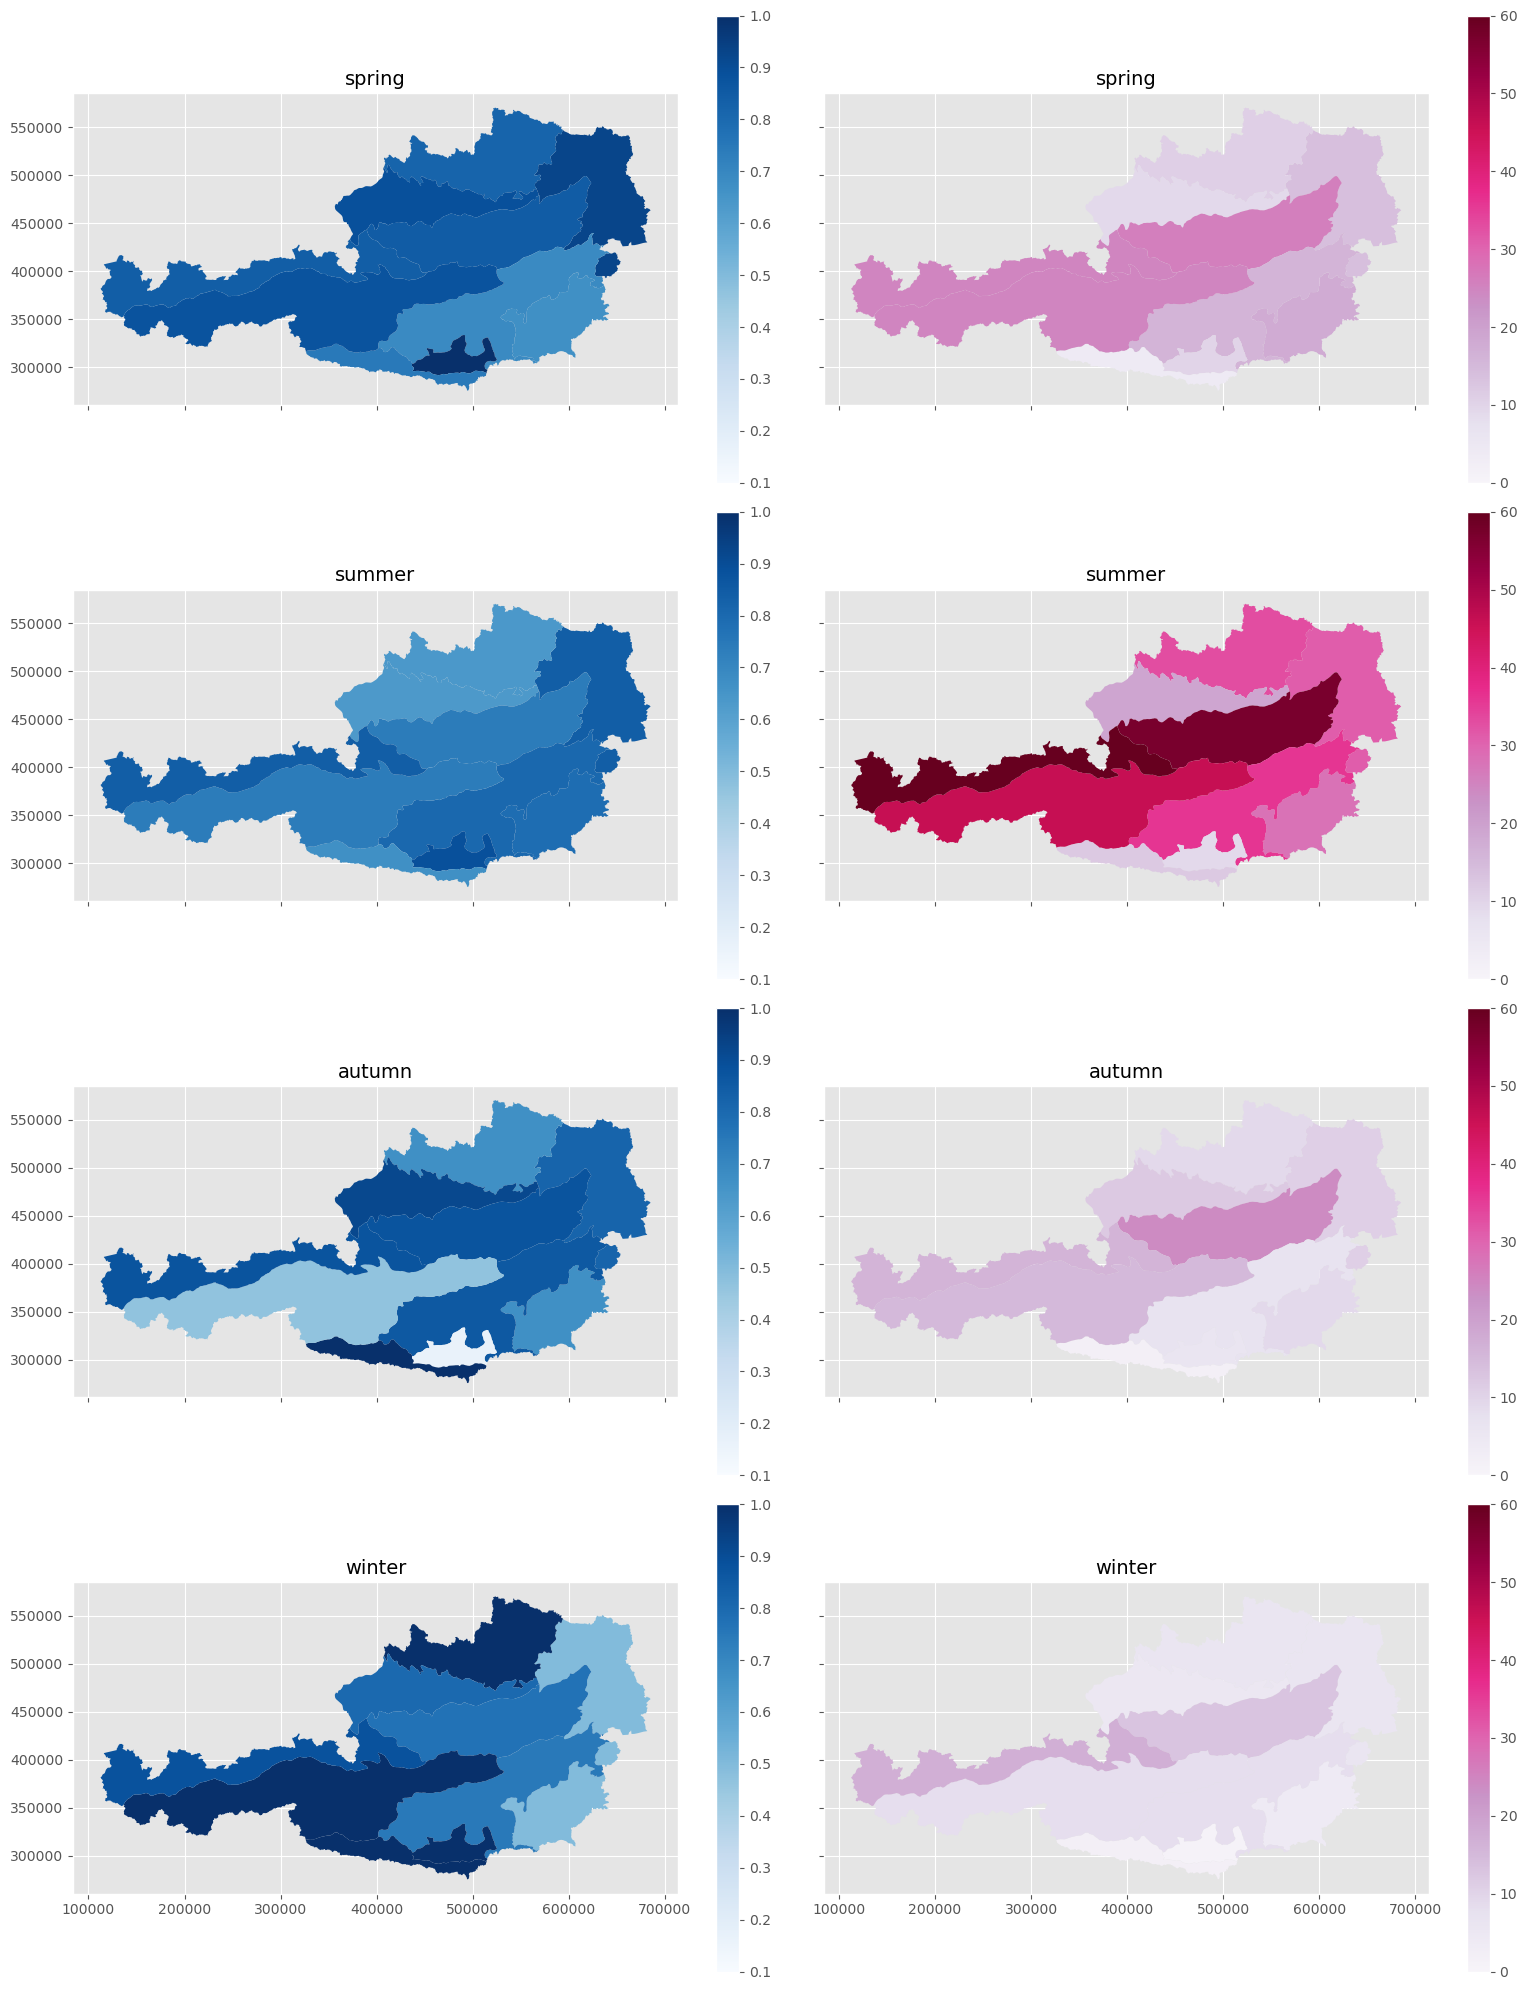

In [ ]:
fig, axes = plt.subplots(4, 2, figsize=(16, 20), sharex="col", sharey="row")
seasons = ["spring", "summer", "autumn", "winter"]

for i in temporal_groups:
    gdf = pd.merge(naturraumregionen, preds_st_grouped[preds_st_grouped.temporal_group == i], left_on="EINHEIT_encoded", right_on="spatial_group")
    im1 = gdf.plot(column="accuracy", cmap="Blues", legend=True, ax=axes[i, 0], vmin=0.1, vmax=1, legend_kwds={"shrink":.5})
    im2 = gdf.plot(column="sample_size", cmap="PuRd", legend=True, ax=axes[i, 1], vmin=0, vmax=60, legend_kwds={"shrink":.5})

    axes[i, 0].set_title(f'{seasons[i]}', fontsize=14) 
    axes[i, 1].set_title(f'{seasons[i]}', fontsize=14) 

plt.tight_layout()
plt.show()
    